In [1]:
import datetime
import math
import pathlib
import re

import tqdm

import rosbag
import geometry_msgs.msg as geomsg
import message_filters

import cameratransform as ct
from tf.transformations import quaternion_from_euler, euler_from_quaternion
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import numpy as np
import cv2


from cv_bridge import CvBridge

import torch
import torchvision
import av
import postprocess

In [2]:
!ls ..

GazeboRosPkgs		     events.npz			       record_0.1.bag
Models			     events.pt			       rosbag2video.py
NRPExp_DVSDatabaseGenerator  gazebo_actor-updaterate_patch.sh  setup.sh
README.md		     logs.zip			       src
Scripts_deprecated	     nrp_installer.sh
Untitled.ipynb		     rb


In [3]:
bag = rosbag.Bag("../record_0.1.bag")
#model_topic = "/gazebo/model_states"
model_topic = "/gazebo_modelstates_with_timestamp"
camera_topic = "/robot/camera_rgb_00"
event_topic = "/robot/camera_dvs_00/events"
bridge = CvBridge()
g = postprocess.process_bag(bag, bridge, model_topic, camera_topic, event_topic)

In [ ]:
c = 0
for topic, msg, t in bag.read_messages(topics=[camera_topic]):
#    d = {n: i for i, n in enumerate(msg.name)}
#     i = d["animated camera::eye_vision_camera"]
    #msg.events = None
    #print(msg)
    print(hasattr(msg, 'gazebo_model_states_header'))
    print(postprocess.message_to_time(msg))
    c += 1
    if c > 100:
        break

In [4]:
camera_poses = postprocess.camera_pose_generator(bag, model_topic)
images = postprocess.image_generator(bag, bridge, camera_topic)
events = postprocess.event_generator(bag, event_topic)

In [ ]:
ga = postprocess.align_generators(camera_poses, images, events)

In [ ]:
for x in ga:
    print(list(x))
    break

In [ ]:
def image_labels(camera, tool_poses, tool_meshes):
    images = []
    for tool_class, (tool, pose) in enumerate(tool_poses.items()):
        raw_vertices, raw_triangles = tool_meshes[tool]
        transformed = transform_tool(raw_vertices, pose)
        projection = camera.imageFromSpace(transformed)
        triangles = np.take(projection, raw_triangles, axis=0).astype(int)
        image_class = np.zeros((512, 512))
        for mesh in triangles:
            cv2.fillConvexPoly(image_class, mesh, tool_class + 1)
        images.append(image_class)
    return np.stack(images, -1)

In [ ]:
def transform_tool(mesh, pose):
    orientation = pose.orientation
    orientation_quat = np.array(
        [orientation.x, orientation.y, orientation.z, orientation.w]
    )
    rotation = Rotation.from_quat(orientation_quat)
    rotation_corrected = rotation.as_euler('xyz')
    rotation = Rotation.from_euler('xyz', rotation_corrected)
    position = np.array([pose.position.x, pose.position.y, pose.position.z])
    return position + rotation.apply(mesh)

In [ ]:
def camera_transform_generator(pose, focal_length=0.5003983220157445 * 512):
    for t, (x, y, z, roll, pitch, yaw) in camera_pose_generator:
        (roll, pitch, yaw) = (radians / 180 * np.pi for radians in (roll, pitch, yaw))
        projection = ct.RectilinearProjection(
            focallength_px=focal_length, image=(512, 512)
        )
        orientation = ct.SpatialOrientation(
            pos_x_m=x,
            pos_y_m=y,
            elevation_m=z,
            roll_deg=roll, # TODO: Specify
            tilt_deg=90 - pitch,
            heading_deg=90 - yaw,
        )
        yield t, ct.Camera(projection, orientation)

In [8]:
#for x in range(10):
out = next(g)

In [ ]:
(image, camera, camera_pose, tool_poses, tool_meshes, labels, event, times) = out
(x, y, z, roll, pitch, yaw) = camera_pose
(roll, pitch, yaw) = (radians * 180 / np.pi for radians in (roll, pitch, yaw))
projection = ct.RectilinearProjection(
   focallength_px=0.5003983220157445 * 512, image=(512, 512)
)
orientation = ct.SpatialOrientation(
   pos_x_m=x, pos_y_m=y, elevation_m=z,
   roll_deg=roll, tilt_deg=90-pitch, heading_deg=90-yaw,
)
camera2 = ct.Camera(projection, orientation)
label = image_labels(camera2, tool_poses, tool_meshes)
print(camera.getPos())
print(times)
#plt.imshow(image)
#plt.imshow(image / 400  + labels)
plt.imshow(event / 400  + labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


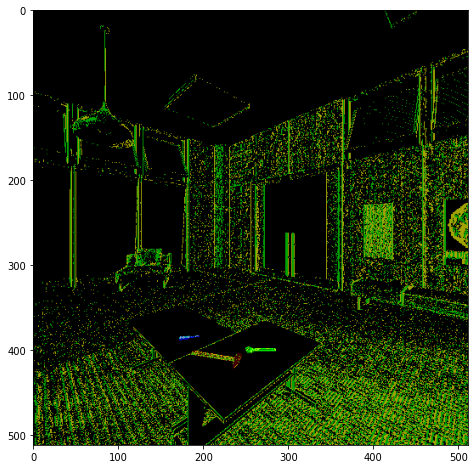

NameError: name 'cl' is not defined

In [10]:
plt.figure(figsize=(16, 8))
(image, events, labels) = out
#images = image_labels(camera, tool_poses, tool_meshes)
#cl = images[0] + images[1] + images[2]
#cl = np.broadcast_to(np.expand_dims(cl, 2), (512, 512, 3))
plt.imshow(events / 400 + labels / 4)
#plt.imshow(labels)
plt.show()
cl.min(), cl.max(), cl.mean(), times

In [ ]:
plt.imshow(images[4])x

In [ ]:
rr =np.array([0, 0.78, 0.78]) - r.as_euler('xyz')
Rotation.from_euler('xyz', rr)

In [ ]:
for image, camera_pose, tool_poses, tool_meshes, times in g:
    (x, y, z, roll, pitch, yaw) = camera_pose
    (roll, pitch, yaw) = (radians * 180 / np.pi for radians in (roll, pitch, yaw))
    projection = ct.RectilinearProjection(
        focallength_px=0.5003983220157445 * 512, image=(512, 512)
    )
    orientation = ct.SpatialOrientation(
        pos_x_m=x + 0.04, pos_y_m=y - 0.08, elevation_m=z + 1.0,
        roll_deg=roll+11, tilt_deg=90-pitch, heading_deg=90-yaw,
    )
    camera = ct.Camera(projection, orientation)
    print(x, y, z, roll, pitch, yaw, camera_pose[3:])

    images = image_labels(camera, tool_poses, tool_meshes)
    cl = images[0] + images[1] + images[2]
    cl = np.broadcast_to(np.expand_dims(cl, 2), (512, 512, 3))
    plt.imshow(image / 300 + cl)
    plt.show()
    cl.min(), cl.max(), cl.mean(), times

In [ ]:
import torch
images = []
events = []
labels = []
for rgb, camera, camera_pose, poses, meshes, label, event, (tc, ti, te) in tqdm.tqdm(g):
    images.append(torch.tensor(rgb))
    events.append(torch.tensor(event))
    labels.append(torch.tensor(label))

In [ ]:
len(images)

In [ ]:
plt.imshow(events[100])

In [ ]:
torch_images = torch.stack([torch.tensor(x) for x in images])
#torch_events = torch.stack([torch.tensor(x) for x in events])
torch_labels = torch.stack([torch.tensor(x) for x in labels])

In [ ]:
torchvision.io.write_video("h.mp4", torch_images / 3 + torch_labels * 100, fps=1)

In [ ]:
!ls ../data

In [ ]:
!ls ../data

In [ ]:
from natsort import natsorted

dataset = "../data/datasetdvs_2021-06-16-19-23-07"
files = !ls $dataset
sorted_files = natsorted(files)
len(sorted_files)

In [ ]:
import tqdm
file_images = []
file_labels = []
for file in tqdm.tqdm(sorted_files):
    with np.load(f"{dataset}/{file}") as data:
        rgb = data['images'] / 300
        label = data['labels']
        file_images.append(rgb)
        file_labels.append(label)

In [ ]:
plt.imshow(file_labels[1])

In [ ]:
plt.imshow(images[2])

In [ ]:
labels[2].shape

In [ ]:
plt.imshow(labels)

In [ ]:
i = 2
plt.imshow(labels[i].sum(2))

In [ ]:
ims = torch.stack([torch.tensor(x) for x in images])

In [ ]:
torchvision.io.write_video("h.mp4", ims, fps=20)